In [1]:
import math
import random
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

In [2]:
class NeuralNetwork:
    
    def __init__(self,  lr, momentum,_lambda, input_dims, hidden_neurons, output_dims):
        # initializing variables for our neural network class using constructor
        self.lmbda = _lambda
        self.learning_rate = lr
        self.momentum = momentum
        self.weights = []
        self.bias = [1,1]
        self.layer_weights = [1] * hidden_neurons
        self.delta_weights = []
    
    def sigmoid(self,x):
        # our activation function
        return 1 / (1 + np.exp(-self.lmbda * x))
    
    def init_weights(self, _layer, _input_dims, _output_dims):
        # initializing 3d weights which will carry our weights of each neuron connection in each layer, 1st dimension is layer, second is associated with input layer,
        # third is associated with output layer
        self.weights.append([])
        for i in range(_input_dims+1):  # +1 for bias
            self.weights[_layer].append([])
            self.weights[_layer][i] = [float(random.uniform(-1,1)) for i in range(_output_dims)]
    
    def init_delta_weights(self):
        # initializing 3d weights which will carry our delta weights (i.e change of weights) of each neuron connection in each layer, 1st dimension is layer, second is associated with input layer,
        # third is associated with output layer
        for i in range(len(self.weights)):
            self.delta_weights.append([])
            for j in range(len(self.weights[i])):
                self.delta_weights[i].append([])
                for k in self.weights[i][j]:
                    self.delta_weights[i][j].append(0)
    
    def performance_measure(self, x, y):
        # rmse error function for evaluating the model performance
        e = (x - y)**2
        e = np.sum(e,axis = 1)/2
        print(math.sqrt(np.sum(e,axis = 0)/len(e)),end=' ')
        return math.sqrt(np.sum(e,axis = 0)/len(e))
    
    def forward_pass(self, _inputs):
        # forward propagation which multiplies weights and calculate the new layer weights after applying 
        # the activation function, sigmoid in our case
        self.layer_weights = self.sigmoid(np.dot(np.transpose(self.weights[0]), np.hstack((_inputs, [self.bias[0]]))))
#         self.layer_weights = self.sigmoid(np.dot(np.transpose(self.weights[0]), _inputs))
        # result is the resultant 2 values after our forward pass is completed with the updated weights
        _result = self.sigmoid(np.dot(np.transpose(self.weights[1]), np.hstack((self.layer_weights,[self.bias[1]]))))
#         _result = self.sigmoid(np.dot(np.transpose(self.weights[1]),self.layer_weights))
        self.layer_weights = np.transpose(np.array(self.layer_weights))
        return _result
    
    def backpropagation(self, inputs, outputs, real_outputs):
        # backward pass to update the weights using gradient descent algorithm
        
        # this loop calculates error 
        error = []
        for i in range(0, len(real_outputs)):
            error.append(float(real_outputs[i]) - float(outputs[i]))

        # this loop calculates gradient value for our 2nd layer
        delta_val = []
        for i in range(0, len(outputs)):
            delta_val.append(self.lmbda * outputs[i] * (1 - outputs[i]) * error[i] )

        # this loop calculates gradient value for our 1st layer
        delta_val_1 = [] 
        for i in range(0, len(self.layer_weights)):
            result = 0
            for j in range(0, len(outputs)):
                result = result + ( float(delta_val[j]) * float(self.weights[1][i][j]) ) 

            delta_val_1.append(self.lmbda * self.layer_weights[i] * (1 - self.layer_weights[i]) * result)
        
        # this loop calculates delta weights for our 2nd layer using gradient value of 2nd layer calculated before
        for i in range(0, len(self.layer_weights)+1):
            for j in range(0, len(outputs)):
                self.delta_weights[1][i][j] = self.learning_rate * float(delta_val[j]) * float(np.hstack((self.layer_weights,[self.bias[1]]))[i])  + self.momentum * self.delta_weights[1][i][j]
#                 self.delta_weights[1][i][j] = self.learning_rate * float(delta_val[j]) * float(self.layer_weights[i])  + self.momentum * self.delta_weights[1][i][j]

        # this loop calculates delta weights for our 1st layer using gradient value of 1st layer calculated before
        for i in range(0, len(inputs)+1):
            for j in range(0, (len(self.layer_weights) - 1)):
                self.delta_weights[0][i][j] = self.learning_rate * float(delta_val_1[j]) * float(np.hstack((inputs,[self.bias[0]]))[i])  + self.momentum * self.delta_weights[0][i][j]
#                 self.delta_weights[0][i][j] = self.learning_rate * float(delta_val_1[j]) * float(inputs[i])  + self.momentum * self.delta_weights[0][i][j]

        # this loop updates weights for our 2nd layer using delta weights of layer 2 calculated before
        for i in range(0, len(self.layer_weights)+1):
            for j in range(0, len(self.weights[1][i])):
                self.weights[1][i][j] = float(self.weights[1][i][j]) + float(self.delta_weights[1][i][j])

        # this loop updates weights for our 1st layer using delta weights of layer 1 calculated before
        for i in range(0, len(inputs)+1):
            for j in range(0, len(self.weights[0][i])):
                self.weights[0][i][j] = float(self.weights[0][i][j]) + float(self.delta_weights[0][i][j])
    
    def training(self, df, y, no_epochs, test_Size, show_graph, stopping_condition):
        # this function trains our network
        
        # intializing variables for storing loss data to calculate graph afterwards
        real = []
        pred = []
        pred_test = []
        real_test = []
        
        epochs = []
        rms_train = []
        rms_test = []
        index = 0
        
        # iterating over the whole data again and again to train better
        for i in range(no_epochs):

            print("\nepoch : "+ str(i),end = " , error : ")
            
            #randomizing the training and testing sample before training each epoch
            df = df.sample(frac=1).reset_index(drop=True)
            
            #split the data into training and validation
            x_train, x_test, y_train, y_test = train_test_split( df, y, test_size = test_Size, random_state = i)
            
            # training the model and updating its weights
            for x in range(len(x_train)):
                _result = self.forward_pass(np.transpose(np.array(x_train.iloc[x])))
                real.append(y_train[x])
                pred.append(_result)
                self.backpropagation(np.array(x_train.iloc[x]),_result, np.array(y_train[x]))
            
            # evaluating the model performance on validation dataset
            for x in range(len(x_test)):
                _result = self.forward_pass(np.transpose(np.array(x_test.iloc[x])))
                real_test.append(y_test[x])
                pred_test.append(_result)

            # adding the loss values in the array to plot graph
            pm_train = self.performance_measure(pred,np.array(real))
            pm_test = self.performance_measure(pred_test,np.array(real_test))
            rms_train.append(pm_train)
            rms_test.append(pm_test)
            epochs.append(index)
            index += 1
            
            # every 10th epoch create a plot for train and validation loss
            if(show_graph and i%10 == 0 and i != 0):
                
                fig, ax = plt.subplots()
                fig.set_size_inches(1,1)

                ax.plot(epochs, rms_train)
                ax.plot(epochs, rms_test)

                ax.set(xlabel='epochs', ylabel='loss', title='')
            
                plt.show()
            
            # stop the training if 3 digits after decimal are equal that means both training and validation is converging
            if(stopping_condition):
                if(int(pm_train * 10000) == int(pm_test * 10000)):
                    break
        
        # plot the final graph after all epochs are completed
        self.final_plot(epochs, rms_train, rms_test)
    
    def final_plot(self, epochs, rms_train, rms_test):
        # this function plots the final graph for training
        
        fig, ax = plt.subplots()
        ax.plot(epochs, rms_train)
        ax.plot(epochs, rms_test)

        ax.set(xlabel='epochs', ylabel='loss',
               title='')
        ax.grid()

        fig.savefig("test.png")
        plt.show()
    
    def prediction(x):
        # this function predicts the x data value
        return np.transpose(forward_pass(np.transpose(np.array(x))))
    
    def write_weights(self):
        # this function writes the weights and layer values in the files
        np.savetxt('layer_weights2.txt', self.layer_weights)
        np.savetxt('weights2.txt', self.weights[0])
        np.savetxt('weights_12.txt', self.weights[1])
    
    def read_weights(self):
        # this function read the weights and layer values from the files
        self.layer_weights = np.loadtxt('layer_weights2.txt', dtype=float)
        self.weights = [[],[]]
        self.weights[0] = np.loadtxt('weights2.txt', dtype=float)
        self.weights[1] = np.loadtxt('weights_12.txt', dtype=float)

In [3]:
# read the data

df = pd.read_csv("ce889_dataCollection.csv", header=None)
# df = pd.read_csv("C:/Users/saada/Desktop/normalized_training.csv", header=None)
df.head()

,0,1,2,3
0,43.238163,431.9,0.0,0.00
1,43.238163,431.9,-0.1,0.04
2,43.198163,432.0,-0.2,0.00
3,43.198163,432.2,-0.3,0.04
4,43.158163,432.5,-0.4,0.00


In [4]:
# get all negative data values and randomize the sample

neg_df = df[df[0]<0]
neg_df = neg_df.sample(frac=1).reset_index(drop=True)    


print('negative values = '+str(len(neg_df)))

# get all positive data values and randomize the sample

pos_df = df[df[0]>=0]
pos_df = pos_df.sample(frac=1).reset_index(drop=True)


print('positive values = '+str(len(pos_df)))

# merge the same number of negative and positive values for stratification and randomize the sample again

neg_df = neg_df.iloc[:min(len(pos_df),len(neg_df))]
neg_df = [neg_df, neg_df.sample(frac=1).reset_index(drop=True)[0: max(len(pos_df),len(neg_df)) - min(len(pos_df),len(neg_df)) ] ]
neg_df = pd.concat(neg_df)

print('negative values = '+str(len(neg_df)))

pos_df = pos_df.iloc[:min(len(pos_df),len(neg_df))]

print('positive values = '+str(len(pos_df)))

df = [neg_df, pos_df]
df = pd.concat(df)
df = df.sample(frac=1).reset_index(drop=True)   

negative values = 4184
positive values = 6524
negative values = 6524
positive values = 6524


In [5]:
# df = (df - df.min()) / (df.max() - df.min())
# df.to_csv('normalized_game.csv', sep=',', index= False, header= None)

In [6]:
df.head()

,0,1,2,3
0,-33.442151,212.530840,-0.004919,-0.786623
1,-480.885996,429.900000,0.700000,0.040000
2,69.507284,247.660946,-0.345235,1.230870
3,-13.837557,186.973170,0.980721,-0.165896
4,226.389803,260.126369,0.164640,1.934999


In [7]:
# seperate target and input values and extract min and max values for each column

x_target = df[2]
y_target = df[3]

df = df.drop(2,axis = 1)
df = df.drop(3,axis = 1)

y = np.transpose([x_target,y_target])

ymax_0, ymin_0, ymax_1, ymin_1 = np.transpose(y)[0].max(),np.transpose(y)[0].min(),np.transpose(y)[1].max(),np.transpose(y)[1].min()
xmax_0, xmax_1, xmin_0, xmin_1 = df[0].max(),df[1].max(),df[0].min(),df[1].min()

In [8]:
xmax_0, xmax_1, xmin_0, xmin_1 # = (806.4610465928558, 632.8696656331233, -725.2383418207205, 65.00338781766072)

(795.2104474142598, 443.3318089433691, -540.428193201501, 65.21097854954758)

In [9]:
ymax_0, ymin_0, ymax_1, ymin_1 # = (7.999999999999988, -4.325720977420088, 6.388370661289141, -7.7609076188105135)

(7.999999999999988, -2.742634266708001, 5.01526751404047, -5.603767509880821)

In [10]:
x_target[np.array(df[0])>=0] = 1
x_target[np.array(df[0])<0] = 0
y_target[np.array(df[1]>=0 )] = 0.4
y = np.transpose([x_target,y_target])

In [11]:
# apply min max scaling on data

df = (df - df.min()) / (df.max() - df.min())
# y = (y - y.min()) / (y.max() - y.min())

In [12]:
# init network configs and data

_learning_rate = 0.8
_momentum = 0.03
_lambda = 0.6

_input_dims = 2
_no_neurons = 4
_output_dims = 2

network = NeuralNetwork(_learning_rate, _momentum, _lambda, _input_dims, _no_neurons, _output_dims)
network.init_weights(0, _input_dims, _no_neurons)
network.init_weights(1, _no_neurons, _output_dims)
network.init_delta_weights()


epoch : 0 , error : 0.35686290864013537 0.37350522615089693 
epoch : 1 , error : 0.3564904297402535 0.36471400679122357 
epoch : 2 , error : 0.3562067529370734 0.3626268510049889 
epoch : 3 , error : 0.3560855781681377 0.3605647673828256 
epoch : 4 , error : 0.35605362842709537 0.358989191462248 
epoch : 5 , error : 0.35594694946077593 0.35963798367144795 
epoch : 6 , error : 0.3558652493081351 0.3587475212069545 
epoch : 7 , error : 0.35586396022188976 0.3580620921942134 
epoch : 8 , error : 0.35584981921247144 0.3576367004193754 
epoch : 9 , error : 0.35584340428661226 0.357248617210295 
epoch : 10 , error : 0.3558169176172241 0.3577561139506901 

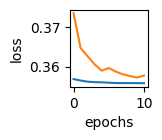


epoch : 11 , error : 0.35582556412972693 0.35743282770920387 
epoch : 12 , error : 0.3558288809730468 0.35714157409455616 
epoch : 13 , error : 0.35583376911834286 0.35679208773523374 
epoch : 14 , error : 0.3558345098943527 0.3582893285342745 
epoch : 15 , error : 0.3558127564982798 0.357791565343781 
epoch : 16 , error : 0.35580224395380194 0.35784410418817564 
epoch : 17 , error : 0.355814497274057 0.3576748880697358 
epoch : 18 , error : 0.3558147943385381 0.3575431984688554 
epoch : 19 , error : 

KeyboardInterrupt: 

In [13]:
# init model configs and train the network

epochs = 2000
test_size = 0.005
show_graph = True
stopping_condition = False
network.training(df, y, epochs, test_size, show_graph, stopping_condition)

In [ ]:
network.write_weights()